# Data ETL

## Extraction

## Transformation

In [1]:
# Dependencies and models
import pandas as pd
import numpy as np

In [2]:
# Import cleaned data 
df = pd.read_csv('cleaned_data.csv')
pd.set_option('display.max_columns', None)
df.head(2)

,title,rated,released,runtime,director,writer,actors,plot,language,country,awards,metascore,imdbrating,imdbvotes,dvd,boxoffice,response,genre,star,budget,gross,year,internet_movie_database_rating,rotten_tomato_rating,metacritic_rating
0,Inception,PG-13,2010-07-16,148,Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",A thief who steals corporate secrets through t...,"English, Japanese, French","United Kingdom, United States",Won 4 Oscars. 157 wins & 220 nominations total,74.0,8.8,2223702,07 Dec 2010,292576195.0,True,Action,Leonardo DiCaprio,160000000.0,836836967.0,2010,8.8,87.0,74.0
1,Iron Man 2,PG-13,2010-05-07,124,Jon Favreau,"Justin Theroux, Stan Lee, Don Heck","Robert Downey Jr., Mickey Rourke, Gwyneth Paltrow",With the world now aware of his identity as Ir...,"English, French, Russian",United States,Nominated for 1 Oscar. 7 wins & 44 nominations...,57.0,7.0,771885,17 Aug 2010,312433331.0,True,Action,Robert Downey Jr.,200000000.0,623933331.0,2010,7.0,72.0,57.0


In [3]:
# Replacing nulls with 'NA' and 0

df["rated"].fillna("NA", inplace = True)
df["director"].fillna("NA", inplace = True)
df["writer"].fillna("NA", inplace = True)
df["language"].fillna("NA", inplace = True)
df["country"].fillna("NA", inplace = True)
df["awards"].fillna("NA", inplace = True)
df["metascore"].fillna(0, inplace = True)
df["dvd"].fillna("NA", inplace = True)
df["boxoffice"].fillna(0, inplace = True)
df["budget"].fillna(0, inplace = True)
df["gross"].fillna(0, inplace = True)

# Check for any nulls 

df.isnull().sum()

title                             0
rated                             0
released                          0
runtime                           0
director                          0
writer                            0
actors                            0
plot                              0
language                          0
country                           0
awards                            0
metascore                         0
imdbrating                        0
imdbvotes                         0
dvd                               0
boxoffice                         0
response                          0
genre                             0
star                              0
budget                            0
gross                             0
year                              0
internet_movie_database_rating    0
rotten_tomato_rating              0
metacritic_rating                 0
dtype: int64

# Exploratory Data Analysis

# Machine Learning Model

## Data Preprocessing

### Adding label column based on IMDB Rating (rating(<5): label 0,rating(>=5 and <8):label1,rating(>8):label2

In [4]:
df['label']=''
for index, row in df.iterrows():
    if (row['imdbrating']<5):
        df.loc[index, 'label']=0
    elif (row['imdbrating']>=5)&(row['imdbrating']<8):
        df.loc[index, 'label']=1
    elif (row['imdbrating']>=8):
        df.loc[index, 'label']=2

In [5]:
df

,title,rated,released,runtime,director,writer,actors,plot,language,country,awards,metascore,imdbrating,imdbvotes,dvd,boxoffice,response,genre,star,budget,gross,year,internet_movie_database_rating,rotten_tomato_rating,metacritic_rating,label
0,Inception,PG-13,2010-07-16,148,Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",A thief who steals corporate secrets through t...,"English, Japanese, French","United Kingdom, United States",Won 4 Oscars. 157 wins & 220 nominations total,74.0,8.8,2223702,07 Dec 2010,292576195.0,True,Action,Leonardo DiCaprio,160000000.0,836836967.0,2010,8.8,87.0,74.0,2
1,Iron Man 2,PG-13,2010-05-07,124,Jon Favreau,"Justin Theroux, Stan Lee, Don Heck","Robert Downey Jr., Mickey Rourke, Gwyneth Paltrow",With the world now aware of his identity as Ir...,"English, French, Russian",United States,Nominated for 1 Oscar. 7 wins & 44 nominations...,57.0,7.0,771885,17 Aug 2010,312433331.0,True,Action,Robert Downey Jr.,200000000.0,623933331.0,2010,7.0,72.0,57.0,1
2,Shutter Island,R,2010-02-19,138,Martin Scorsese,"Laeta Kalogridis, Dennis Lehane","Leonardo DiCaprio, Emily Mortimer, Mark Ruffalo","In 1954, a U.S. Marshal investigates the disap...","English, German",United States,11 wins & 66 nominations,63.0,8.2,1225928,08 Jun 2010,128012934.0,True,Mystery,Leonardo DiCaprio,80000000.0,294805697.0,2010,8.2,68.0,63.0,2
3,Scott Pilgrim vs. the World,PG-13,2010-08-13,112,Edgar Wright,"Michael Bacall, Edgar Wright, Bryan Lee O'Malley","Michael Cera, Mary Elizabeth Winstead, Kieran ...","In a magically realistic version of Toronto, a...",English,"United States, United Kingdom, Canada, Japan",17 wins & 64 nominations,69.0,7.5,409720,09 Nov 2010,32777690.0,True,Action,Michael Cera,60000000.0,48917974.0,2010,7.5,82.0,69.0,1
4,Grown Ups,PG-13,2010-06-25,102,Dennis Dugan,"Adam Sandler, Fred Wolf","Adam Sandler, Salma Hayek, Kevin James",After their high school basketball coach passe...,"English, Spanish",United States,3 wins & 4 nominations,30.0,6.0,242283,09 Nov 2010,162001186.0,True,Comedy,Adam Sandler,80000000.0,271457301.0,2010,6.0,11.0,30.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,Chasing the Dragon II: Wild Wild Bunch,Not Rated,2019-06-07,101,"Jason Kwan, Jing Wong","Koon-Nam Lui, Jing Wong","Tony Ka Fai Leung, Louis Koo, Ka-Tung Lam",Serial billionaire kidnapper Logan has been sa...,"Cantonese, Mandarin, English","China, Hong Kong",2 nominations,0.0,5.8,606,26 Apr 2020,196634.0,True,Action,Tony Ka Fai Leung,0.0,45738461.0,2019,5.8,75.0,0.0,1
1770,Round of Your Life,NA,2019-06-21,91,Dylan Thomas Ellis,Tim Ogletree,"Cole Allen, Ximena Alvarez, Suhail Arastu",Fifteen year-old Taylor Collins is a golf lega...,English,United States,NA,0.0,4.7,185,05 Aug 2019,20941.0,True,Family,Cole Allen,0.0,20941.0,2019,4.7,60.0,0.0,0
1771,El Coyote,R,2019-10-04,93,Jeffrey Nicholson,Jeffrey Nicholson,"Michael Saquella, Robert Costanzo, John Capodice",The Italian mob descends on the Mexican border...,English,United States,NA,0.0,3.0,145,NA,1101470.0,True,Action,Michael Saquella,0.0,1101470.0,2019,3.0,0.0,0.0,0
1772,By Light of Desert Night,NA,2020-03-03,94,David Stuart Snell,David Stuart Snell,"Meghan Carrasquillo, Alexandra Bokova, Gus Lan...",Three best friends head on a road trip into th...,English,United States,3 nominations,0.0,4.8,1602,28 Feb 2020,0.0,True,Drama,Alexandra Bokova,0.0,0.0,2020,4.8,0.0,0.0,0


In [6]:
df['label'].value_counts()

1    1622
0      78
2      74
Name: label, dtype: int64

In [7]:
df['label'].dtype

dtype('O')

In [8]:
df['label']=pd.to_numeric(df['label'])
df['label'].fillna(0,inplace=True)
df['label']=df['label'].astype('int')

In [9]:
df['label']

0       2
1       1
2       2
3       1
4       1
       ..
1769    1
1770    0
1771    0
1772    0
1773    1
Name: label, Length: 1774, dtype: int64

In [10]:
df

,title,rated,released,runtime,director,writer,actors,plot,language,country,awards,metascore,imdbrating,imdbvotes,dvd,boxoffice,response,genre,star,budget,gross,year,internet_movie_database_rating,rotten_tomato_rating,metacritic_rating,label
0,Inception,PG-13,2010-07-16,148,Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",A thief who steals corporate secrets through t...,"English, Japanese, French","United Kingdom, United States",Won 4 Oscars. 157 wins & 220 nominations total,74.0,8.8,2223702,07 Dec 2010,292576195.0,True,Action,Leonardo DiCaprio,160000000.0,836836967.0,2010,8.8,87.0,74.0,2
1,Iron Man 2,PG-13,2010-05-07,124,Jon Favreau,"Justin Theroux, Stan Lee, Don Heck","Robert Downey Jr., Mickey Rourke, Gwyneth Paltrow",With the world now aware of his identity as Ir...,"English, French, Russian",United States,Nominated for 1 Oscar. 7 wins & 44 nominations...,57.0,7.0,771885,17 Aug 2010,312433331.0,True,Action,Robert Downey Jr.,200000000.0,623933331.0,2010,7.0,72.0,57.0,1
2,Shutter Island,R,2010-02-19,138,Martin Scorsese,"Laeta Kalogridis, Dennis Lehane","Leonardo DiCaprio, Emily Mortimer, Mark Ruffalo","In 1954, a U.S. Marshal investigates the disap...","English, German",United States,11 wins & 66 nominations,63.0,8.2,1225928,08 Jun 2010,128012934.0,True,Mystery,Leonardo DiCaprio,80000000.0,294805697.0,2010,8.2,68.0,63.0,2
3,Scott Pilgrim vs. the World,PG-13,2010-08-13,112,Edgar Wright,"Michael Bacall, Edgar Wright, Bryan Lee O'Malley","Michael Cera, Mary Elizabeth Winstead, Kieran ...","In a magically realistic version of Toronto, a...",English,"United States, United Kingdom, Canada, Japan",17 wins & 64 nominations,69.0,7.5,409720,09 Nov 2010,32777690.0,True,Action,Michael Cera,60000000.0,48917974.0,2010,7.5,82.0,69.0,1
4,Grown Ups,PG-13,2010-06-25,102,Dennis Dugan,"Adam Sandler, Fred Wolf","Adam Sandler, Salma Hayek, Kevin James",After their high school basketball coach passe...,"English, Spanish",United States,3 wins & 4 nominations,30.0,6.0,242283,09 Nov 2010,162001186.0,True,Comedy,Adam Sandler,80000000.0,271457301.0,2010,6.0,11.0,30.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,Chasing the Dragon II: Wild Wild Bunch,Not Rated,2019-06-07,101,"Jason Kwan, Jing Wong","Koon-Nam Lui, Jing Wong","Tony Ka Fai Leung, Louis Koo, Ka-Tung Lam",Serial billionaire kidnapper Logan has been sa...,"Cantonese, Mandarin, English","China, Hong Kong",2 nominations,0.0,5.8,606,26 Apr 2020,196634.0,True,Action,Tony Ka Fai Leung,0.0,45738461.0,2019,5.8,75.0,0.0,1
1770,Round of Your Life,NA,2019-06-21,91,Dylan Thomas Ellis,Tim Ogletree,"Cole Allen, Ximena Alvarez, Suhail Arastu",Fifteen year-old Taylor Collins is a golf lega...,English,United States,NA,0.0,4.7,185,05 Aug 2019,20941.0,True,Family,Cole Allen,0.0,20941.0,2019,4.7,60.0,0.0,0
1771,El Coyote,R,2019-10-04,93,Jeffrey Nicholson,Jeffrey Nicholson,"Michael Saquella, Robert Costanzo, John Capodice",The Italian mob descends on the Mexican border...,English,United States,NA,0.0,3.0,145,NA,1101470.0,True,Action,Michael Saquella,0.0,1101470.0,2019,3.0,0.0,0.0,0
1772,By Light of Desert Night,NA,2020-03-03,94,David Stuart Snell,David Stuart Snell,"Meghan Carrasquillo, Alexandra Bokova, Gus Lan...",Three best friends head on a road trip into th...,English,United States,3 nominations,0.0,4.8,1602,28 Feb 2020,0.0,True,Drama,Alexandra Bokova,0.0,0.0,2020,4.8,0.0,0.0,0


### Dropping Columns not required for the model

In [11]:
df=df.drop(['title','released','plot','awards','metascore','imdbrating' ,'imdbvotes','dvd',
           'boxoffice','response','gross', 'year','internet_movie_database_rating',
           'rotten_tomato_rating','metacritic_rating'],axis=1)                                                 
df.columns

Index(['rated', 'runtime', 'director', 'writer', 'actors', 'language',
       'country', 'genre', 'star', 'budget', 'label'],
      dtype='object')

In [12]:
cols = ['label', 'rated', 'runtime', 'director', 'writer', 'actors', 'language',
       'country', 'genre', 'star', 'budget']

In [13]:
df = df[cols]

In [14]:
df.head()

,label,rated,runtime,director,writer,actors,language,country,genre,star,budget
0,2,PG-13,148,Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...","English, Japanese, French","United Kingdom, United States",Action,Leonardo DiCaprio,160000000.0
1,1,PG-13,124,Jon Favreau,"Justin Theroux, Stan Lee, Don Heck","Robert Downey Jr., Mickey Rourke, Gwyneth Paltrow","English, French, Russian",United States,Action,Robert Downey Jr.,200000000.0
2,2,R,138,Martin Scorsese,"Laeta Kalogridis, Dennis Lehane","Leonardo DiCaprio, Emily Mortimer, Mark Ruffalo","English, German",United States,Mystery,Leonardo DiCaprio,80000000.0
3,1,PG-13,112,Edgar Wright,"Michael Bacall, Edgar Wright, Bryan Lee O'Malley","Michael Cera, Mary Elizabeth Winstead, Kieran ...",English,"United States, United Kingdom, Canada, Japan",Action,Michael Cera,60000000.0
4,1,PG-13,102,Dennis Dugan,"Adam Sandler, Fred Wolf","Adam Sandler, Salma Hayek, Kevin James","English, Spanish",United States,Comedy,Adam Sandler,80000000.0


### Create Function for one hot encoding of writer, actors,language, country columns

In [15]:
def one_hot_encode(column,new_col_names):
    
    for index, row in df.iterrows():
        item_names=str(row[column]).split(',')
        for y in item_names:
            y=y.strip()
            if y in new_col_names:
                df.loc[index, y]=1
        

### One Hot Endcoding: Country

In [16]:
from collections import Counter
# Find most common country names
countries=df['country'].to_list()

country_list=[]

for x in countries:
    
        country_array = str(x).split(',')
        for y in country_array:
            y=y.strip()
            country_list.append(y)
most_common=Counter(country_list).most_common(10)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('country',new_col_names)

### One Hot Encoding : Language

In [17]:
languages=df['language'].to_list()

language_list=[]

for x in languages:
    
        language_array = str(x).split(',')
        for y in language_array:
            y=y.strip()
            language_list.append(y)
most_common=Counter(language_list).most_common(15)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('language',new_col_names)


### One Hot Encoding :writer

In [18]:
writers=df['writer'].to_list()

writer_list=[]

for x in writers:
    
        writer_array = str(x).split(',')
        for y in writer_array:
            y=y.strip()
            writer_list.append(y)
most_common=Counter(writer_list).most_common(50)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('writer',new_col_names)

### One Hot Encoding :actors

In [19]:
actors=df['actors'].to_list()

actor_list=[]

for x in actors:
    
        actor_array = str(x).split(',')
        for y in actor_array:
            y=y.strip()
            actor_list.append(y)
most_common=Counter(actor_list).most_common(50)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('actors',new_col_names)



In [20]:
df=df.drop(['country','language','writer','actors'],axis=1)

In [21]:
df.columns

Index(['label', 'rated', 'runtime', 'director', 'genre', 'star', 'budget',
       'United States', 'United Kingdom', 'France',
       ...
       'Jessica Chastain', 'Chris Evans', 'Mark Ruffalo', 'Nicolas Cage',
       'Chloë Grace Moretz', 'Johnny Depp', 'Kristen Stewart', 'Amy Adams',
       'Robert De Niro', 'Chris Pine'],
      dtype='object', length=132)

In [22]:
df.shape

(1774, 132)

In [23]:
df.head(5)

,label,rated,runtime,director,genre,star,budget,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,English,Spanish,French,German,Russian,Italian,Japanese,Mandarin,Hindi,Arabic,Ukrainian,Korean,Hebrew,Swedish,Latin,Luc Besson,Nicholas Stoller,Jane Goldman,Allan Loeb,Stan Lee,Sean Anders,Brian Helgeland,Cinco Paul,Ken Daurio,Phil Hay,Sylvester Stallone,Nicholas Sparks,Woody Allen,John Morris,Matthew Vaughn,Ethan Reiff,Dan Fogelman,Matt Manfredi,Peter Straughan,Mark Bomback,Darren Lemke,Jennifer Lee,Jez Butterworth,Jonathan Aibel,Billy Ray,Evan Daugherty,Christopher Markus,Stephen McFeely,Steven Knight,Jeff Pinkner,Gary Dauberman,Christopher Nolan,Michael Bacall,Edgar Wright,Adam Sandler,Leigh Whannell,Joel Coen,Ethan Coen,Christopher McQuarrie,Simon Beaufoy,Adam McKay,Hans Christian Andersen,Chris Buck,Peter Morgan,Noah Baumbach,John-Henry Butterworth,Guillermo del Toro,Chris Morgan,Glenn Berger,Josh Appelbaum,Mark Wahlberg,Michael Fassbender,Liam Neeson,Dwayne Johnson,Steve Carell,Jennifer Lawrence,Owen Wilson,Scarlett Johansson,Matthew McConaughey,Gerard Butler,Matt Damon,Jonah Hill,Bradley Cooper,Keira Knightley,Ryan Reynolds,Emily Blunt,Channing Tatum,Chris Hemsworth,Tom Hardy,Robert Downey Jr.,Cate Blanchett,Emma Stone,Nicole Kidman,Seth Rogen,Anna Kendrick,Kevin Hart,Jesse Eisenberg,Helen Mirren,Robert Pattinson,Joel Edgerton,Rachel McAdams,Rachel Weisz,Naomi Watts,Jake Gyllenhaal,Hugh Jackman,Russell Crowe,Michelle Williams,James Franco,Anne Hathaway,Zac Efron,Jessica Chastain,Chris Evans,Mark Ruffalo,Nicolas Cage,Chloë Grace Moretz,Johnny Depp,Kristen Stewart,Amy Adams,Robert De Niro,Chris Pine
0,2,PG-13,148,Christopher Nolan,Action,Leonardo DiCaprio,160000000.0,1,1,,,,,,,,,1,,1,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,PG-13,124,Jon Favreau,Action,Robert Downey Jr.,200000000.0,1,,,,,,,,,,1,,1,,1,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,R,138,Martin Scorsese,Mystery,Leonardo DiCaprio,80000000.0,1,,,,,,,,,,1,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,
3,1,PG-13,112,Edgar Wright,Action,Michael Cera,60000000.0,1,1,,1,,,,1,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,1,PG-13,102,Dennis Dugan,Comedy,Adam Sandler,80000000.0,1,,,,,,,,,,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [24]:
df.fillna(0,inplace=True)


In [25]:
df.isnull().sum()

label              0
rated              0
runtime            0
director           0
genre              0
                  ..
Johnny Depp        0
Kristen Stewart    0
Amy Adams          0
Robert De Niro     0
Chris Pine         0
Length: 132, dtype: int64

### Reducing type of rated by merging two or more types in one

In [26]:
df.loc[df['rated']=='TV-MA', 'rated'] = 'R'
df.loc[df['rated']=='NC-17', 'rated'] = 'R'
df.loc[df['rated']=='TV-14', 'rated'] = 'PG-13'
df.loc[df['rated']=='TV-PG', 'rated'] = 'PG'
df.loc[df['rated']=='Unrated', 'rated'] = 'NA'
df.loc[df['rated']=='Not Rated', 'rated'] = 'NA'

In [27]:
stars = df.star.value_counts()

In [28]:
stars_replace = stars[stars<5].index.to_list()
for star in stars_replace:
  df['star'] =  df['star'].replace(star,'other')

df['star'].value_counts() 

other                  1197
Mark Wahlberg            13
Liam Neeson              12
Matthew McConaughey      12
Matt Damon               12
                       ... 
Naomi Watts               5
Charlize Theron           5
Mia Wasikowska            5
Taron Egerton             5
Julianne Moore            5
Name: star, Length: 82, dtype: int64

In [29]:
df.isnull().sum()

label              0
rated              0
runtime            0
director           0
genre              0
                  ..
Johnny Depp        0
Kristen Stewart    0
Amy Adams          0
Robert De Niro     0
Chris Pine         0
Length: 132, dtype: int64

In [30]:
df.dtypes

label               int64
rated              object
runtime             int64
director           object
genre              object
                    ...  
Johnny Depp        object
Kristen Stewart    object
Amy Adams          object
Robert De Niro     object
Chris Pine         object
Length: 132, dtype: object

In [31]:
directors=df.director.value_counts()

In [32]:
directors_replace = directors[directors<4].index.to_list()
for director in directors_replace:
      df['director'] =  df['director'].replace(director,'other_director')
df.loc[df['director']=='NA', 'director'] = 'other_director'

df['director'].value_counts() 

other_director              1452
Ridley Scott                  10
Robert Schwentke               8
Steven Spielberg               7
Clint Eastwood                 7
                            ... 
Tim Story                      4
Anthony Russo, Joe Russo       4
Sean Anders                    4
Jon Watts                      4
Eli Roth                       4
Name: director, Length: 71, dtype: int64

In [33]:
df_categorical=df[['rated','director','genre','star']]
df=df.drop(['rated','director','genre','star'],axis=1)

In [34]:
df

,label,runtime,budget,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,English,Spanish,French,German,Russian,Italian,Japanese,Mandarin,Hindi,Arabic,Ukrainian,Korean,Hebrew,Swedish,Latin,Luc Besson,Nicholas Stoller,Jane Goldman,Allan Loeb,Stan Lee,Sean Anders,Brian Helgeland,Cinco Paul,Ken Daurio,Phil Hay,Sylvester Stallone,Nicholas Sparks,Woody Allen,John Morris,Matthew Vaughn,Ethan Reiff,Dan Fogelman,Matt Manfredi,Peter Straughan,Mark Bomback,Darren Lemke,Jennifer Lee,Jez Butterworth,Jonathan Aibel,Billy Ray,Evan Daugherty,Christopher Markus,Stephen McFeely,Steven Knight,Jeff Pinkner,Gary Dauberman,Christopher Nolan,Michael Bacall,Edgar Wright,Adam Sandler,Leigh Whannell,Joel Coen,Ethan Coen,Christopher McQuarrie,Simon Beaufoy,Adam McKay,Hans Christian Andersen,Chris Buck,Peter Morgan,Noah Baumbach,John-Henry Butterworth,Guillermo del Toro,Chris Morgan,Glenn Berger,Josh Appelbaum,Mark Wahlberg,Michael Fassbender,Liam Neeson,Dwayne Johnson,Steve Carell,Jennifer Lawrence,Owen Wilson,Scarlett Johansson,Matthew McConaughey,Gerard Butler,Matt Damon,Jonah Hill,Bradley Cooper,Keira Knightley,Ryan Reynolds,Emily Blunt,Channing Tatum,Chris Hemsworth,Tom Hardy,Robert Downey Jr.,Cate Blanchett,Emma Stone,Nicole Kidman,Seth Rogen,Anna Kendrick,Kevin Hart,Jesse Eisenberg,Helen Mirren,Robert Pattinson,Joel Edgerton,Rachel McAdams,Rachel Weisz,Naomi Watts,Jake Gyllenhaal,Hugh Jackman,Russell Crowe,Michelle Williams,James Franco,Anne Hathaway,Zac Efron,Jessica Chastain,Chris Evans,Mark Ruffalo,Nicolas Cage,Chloë Grace Moretz,Johnny Depp,Kristen Stewart,Amy Adams,Robert De Niro,Chris Pine
0,2,148,160000000.0,1,1,,,,,,,,,1,,1,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,124,200000000.0,1,,,,,,,,,,1,,1,,1,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,138,80000000.0,1,,,,,,,,,,1,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,
3,1,112,60000000.0,1,1,,1,,,,1,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,1,102,80000000.0,1,,,,,,,,,,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,1,101,0.0,,,,,1,,,,,,1,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1770,0,91,0.0,1,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1771,0,93,0.0,1,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1772,0,94,0.0,1,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [35]:
df_categorical_dummies=pd.get_dummies(df_categorical)
df_categorical_dummies.shape

(1774, 174)

In [36]:
df=pd.merge(df, df_categorical_dummies, left_index=True, right_index=True)
df.shape

(1774, 302)

In [37]:
for col in df.columns:
    df[col]=pd.to_numeric(df[col])

In [38]:
df=df.fillna(0)

In [39]:
df.isnull().sum()

label                0
runtime              0
budget               0
United States        0
United Kingdom       0
                    ..
star_Vin Diesel      0
star_Will Ferrell    0
star_Will Smith      0
star_Zac Efron       0
star_other           0
Length: 302, dtype: int64

In [40]:
df

,label,runtime,budget,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,English,Spanish,French,German,Russian,Italian,Japanese,Mandarin,Hindi,Arabic,Ukrainian,Korean,Hebrew,Swedish,Latin,Luc Besson,Nicholas Stoller,Jane Goldman,Allan Loeb,Stan Lee,Sean Anders,Brian Helgeland,Cinco Paul,Ken Daurio,Phil Hay,Sylvester Stallone,Nicholas Sparks,Woody Allen,John Morris,Matthew Vaughn,Ethan Reiff,Dan Fogelman,Matt Manfredi,Peter Straughan,Mark Bomback,Darren Lemke,Jennifer Lee,Jez Butterworth,Jonathan Aibel,Billy Ray,Evan Daugherty,Christopher Markus,Stephen McFeely,Steven Knight,Jeff Pinkner,Gary Dauberman,Christopher Nolan,Michael Bacall,Edgar Wright,Adam Sandler,Leigh Whannell,Joel Coen,Ethan Coen,Christopher McQuarrie,Simon Beaufoy,Adam McKay,Hans Christian Andersen,Chris Buck,Peter Morgan,Noah Baumbach,John-Henry Butterworth,Guillermo del Toro,Chris Morgan,Glenn Berger,Josh Appelbaum,Mark Wahlberg,Michael Fassbender,Liam Neeson,Dwayne Johnson,Steve Carell,Jennifer Lawrence,Owen Wilson,Scarlett Johansson,Matthew McConaughey,Gerard Butler,Matt Damon,Jonah Hill,Bradley Cooper,Keira Knightley,Ryan Reynolds,Emily Blunt,Channing Tatum,Chris Hemsworth,Tom Hardy,Robert Downey Jr.,Cate Blanchett,Emma Stone,Nicole Kidman,Seth Rogen,Anna Kendrick,Kevin Hart,Jesse Eisenberg,Helen Mirren,Robert Pattinson,Joel Edgerton,Rachel McAdams,Rachel Weisz,Naomi Watts,Jake Gyllenhaal,Hugh Jackman,Russell Crowe,Michelle Williams,James Franco,Anne Hathaway,Zac Efron,Jessica Chastain,Chris Evans,Mark Ruffalo,Nicolas Cage,Chloë Grace Moretz,Johnny Depp,Kristen Stewart,Amy Adams,Robert De Niro,Chris Pine,rated_G,rated_NA,rated_PG,rated_PG-13,rated_R,"director_Anthony Russo, Joe Russo",director_Antoine Fuqua,director_Baltasar Kormákur,director_Ben Wheatley,director_Brad Peyton,director_Bryan Singer,"director_Chris Buck, Jennifer Lee",director_Christopher Nolan,director_Clint Eastwood,director_Craig Gillespie,director_Daniel Espinosa,director_Danny Boyle,director_David Ayer,director_David Fincher,director_David O. Russell,director_David Yates,director_Denis Villeneuve,director_Dennis Dugan,director_Doug Liman,director_Eli Roth,director_Francis Lawrence,director_Gus Van Sant,director_Guy Ritchie,director_J.J. Abrams,director_Jake Kasdan,director_James Bobin,director_James Wan,director_Jaume Collet-Serra,director_Joe Wright,director_John Erick Dowdle,director_John Madden,director_Jon M. Chu,director_Jon Watts,director_Jonathan Levine,director_Jonathan Liebesman,director_Justin Lin,director_Kenneth Branagh,director_Lars von Trier,director_Lasse Hallström,director_Louis Leterrier,director_Luc Besson,director_Marc Webb,director_Martin Scorsese,director_Matthew Vaughn,director_Michael Bay,director_Michael Dowse,director_Morten Tyldum,director_Nicholas Stoller,director_Noah Baumbach,director_Paul W.S. Anderson,director_Peter Berg,director_Richard Linklater,director_Ridley Scott,director_Robert Schwentke,director_Robert Zemeckis,director_Ron Howard,director_Ruben Fleischer,director_Sean Anders,director_Shawn Levy,director_Simon Curtis,director_Simon West,director_Steven Soderbergh,director_Steven Spielberg,director_Terrence Malick,director_Tim Burton,director_Tim Story,director_Todd Phillips,director_Tom Hooper,director_Wes Ball,director_Woody Allen,director_other_director,genre_Action,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Drama,genre_Family,genre_Fantasy,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Thriller,star_Aaron Taylor-Johnson,star_Adam Sandler,star_Alicia Vikander,star_Andrew Garfield,star_Anna Kendrick,star_Ben Affleck,star_Ben Stiller,star_Brad Pitt,star_Bradley Cooper,star_Channing Tatum,star_Charlize Theron,star_Chris Evans,star_Chris Hemsworth,star_Chris Pine,star_Chris Pratt,star_Christian Bale,star_Daniel Craig,star_Daniel Radcliffe,star_Denzel Washington,star_Dwayne Johnson,star_Dylan O'Brien,star_Eddie Redmayne,star_Ethan Hawke,star_Ew

### Splitting Feature and Target Columns

In [41]:
# Import models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import pickle

In [42]:
X=df.drop('label',axis=1)
y=df['label']

In [43]:
# X = df.iloc[:, 1:302]
# y = df.iloc[:, :1]

In [44]:
X.shape

(1774, 301)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=1)

In [46]:
scaler=StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Trying RandomForest Classifier

In [47]:
model=RandomForestClassifier (random_state=1,n_estimators=500, max_depth=11,min_samples_split=5)
model.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=11, min_samples_split=5, n_estimators=500,
                       random_state=1)

In [48]:
# Save the model as pickle file
pickle.dump(model, open('model.pkl', 'wb'))
# Save the scaler as pickle file
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [49]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [50]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.9210314262691378,testing_score:0.9118198874296435


In [51]:

pred = model.predict(X_test[:1])
pred

array([1])

In [52]:
X_test[:1].count()

runtime              1
budget               1
United States        1
United Kingdom       1
France               1
                    ..
star_Vin Diesel      1
star_Will Ferrell    1
star_Will Smith      1
star_Zac Efron       1
star_other           1
Length: 301, dtype: int64

In [53]:
y_test[:1]

1693    1
Name: label, dtype: int64

### Trying SVC

In [54]:
from sklearn.svm import SVC

In [55]:
model=SVC()
model.fit(X_train_scaled,y_train)

SVC()

In [56]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [57]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.9210314262691378,testing_score:0.9118198874296435


In [58]:
y_test[:1]

1693    1
Name: label, dtype: int64

### Trying K-Nearestneighbors

In [59]:
from sklearn.neighbors import KNeighborsClassifier

In [60]:
train_scores=[]
test_scores=[]

In [61]:
for k in range (1,20,2):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled,y_train)
    train_score=knn.score(X_train_scaled,y_train)
    test_score=knn.score(X_test_scaled,y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)

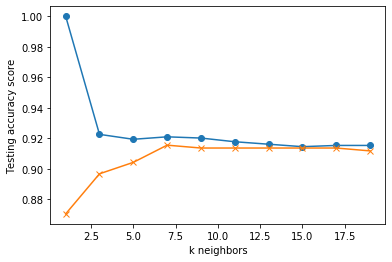

In [62]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

In [63]:
knn=KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_scaled,y_train)


KNeighborsClassifier(n_neighbors=8)

In [64]:
training_score = knn.score(X_train_scaled, y_train)
testing_score = knn.score(X_test_scaled, y_test)

In [65]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.9178082191780822,testing_score:0.9136960600375235


### Trying other ensemble methods

In [66]:
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier

### ExtraTreesClassifier

In [67]:
model=ExtraTreesClassifier()
model.fit(X_train_scaled,y_train)

ExtraTreesClassifier()

In [68]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [69]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.9983883964544722,testing_score:0.8986866791744841


### AdaBoostClassifier

In [70]:
model=AdaBoostClassifier()
model.fit(X_train_scaled,y_train)

AdaBoostClassifier()

In [71]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [72]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.8186946011281225,testing_score:0.8198874296435272
